#Problème:

#Deux cas d'utilisation des données d'opportunité

La qualité de la description d'un phénomène physique dépend des moyens d'observation disponibles. Généralement, les moyens à disposition dépendent de la zone géographique et de la période considérée.
Lorsque les capteurs spécifiques sont (très) peu nombreux, on peut chercher à compléter l'observation par des données supplémentaires issues de capteurs non spécifiques. On parle alors de *données d'opportunité*.

Les *données d'opportunité* peuvent être exploitées à travers par apprentissage. Une approche courante consiste à entraîner un modèle sur la zone où des capteurs spécifiques peuvent fournir une cible de qualité. Le modèle est ensuite porté là où seules les *données d'opportunité* sont disponibles.

Aujourd'hui, on utilise par exemple des données issues des réseaux de télécommunication pour préciser la localisation et l'intensité de phénomènes physiques ou sociaux.  
La première partie est inspirée du cas où la donnée opportune est une atténuation du signal échangé entre les antennes d'un réseau mobile.

On cherche aussi à exploiter des données issues de capteurs de mauvaise qualité qui peuvent être beaucoup plus nombreux que les capteurs spécifiques. C'est ce qu'illustre la seconde partie.

**Note**: les deux parties du problème sont complètement indépendantes.

**Partie I - problème n°1 : régression avec un UNet**

Lancer les imports suivants et se placer dans le dossier *BE_prenomnom*

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
! nvidia-smi # Pour s'assurer de l'accessibilité d'une carte GPU

Wed Jan 10 16:16:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Lien valable jusqu'au 17/01/2024:
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
! mkdir data
from utile_BE import *

--2024-01-10 16:16:57--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27402 (27K) [application/octet-stream]
Saving to: ‘HAnmgiuVNGn_XtdcYCeMNnJ’

HAnmgiuVNGn_XtdcYCe 100%[===================>]  26.76K  --.-KB/s    in 0s      

2024-01-10 16:16:57 (279 MB/s) - ‘HAnmgiuVNGn_XtdcYCeMNnJ’ saved [27402/27402]



Dans ce problème, la cible $T$ est un champ physique scalaire, positif ou nul. On suppose que, dans le meilleur des cas, deux types de capteurs spécifiques sont disponibles.\
Le premier type fournit une mesure spatialisée du champ. Il n'est pas partout disponible. Le second type de capteur fournit une mesure ponctuelle. Ces capteurs sont implantés partout, mais il ne couvrent correctement que 0.5% de la surface.\
En plus de ces capteurs, on suppose qu'on a accès à des données issues d'un réseau de télécommunications. Ces données réflètent l'atténuation d'un signal échangé entre des antennes relais. On suppose que pour chaque signal émis entre deux antennes $A_i$, $A_j$, on peut calculer une quantité $S(A_i,A_j;T)$ qui ne dépend que de la valeur moyenne du champ $T$ sur le trajet entre $A_i$ et $A_j$.

On se place dans le cas où un jeu est constitué sur la zone où la mesure complète du champ est disponible. Pour une première preuve de concept, on travaille avec des images de synthèse sur lesquelles:
- les mesures ponctuelles ont été attribuées aux pixels qui leur correspondent.
- les données d'opportunité sont représentées par des segments. Les extrémités d'un segment représentent deux antennes $A_i$, $A_j$. Le long d'un segment, l'intensité des pixels est  constante, de valeur $S(A_i,A_j;T)$ (seule exception, dans le cas d'intersections, les valeurs sont simplement sommées - voir ci-dessous).

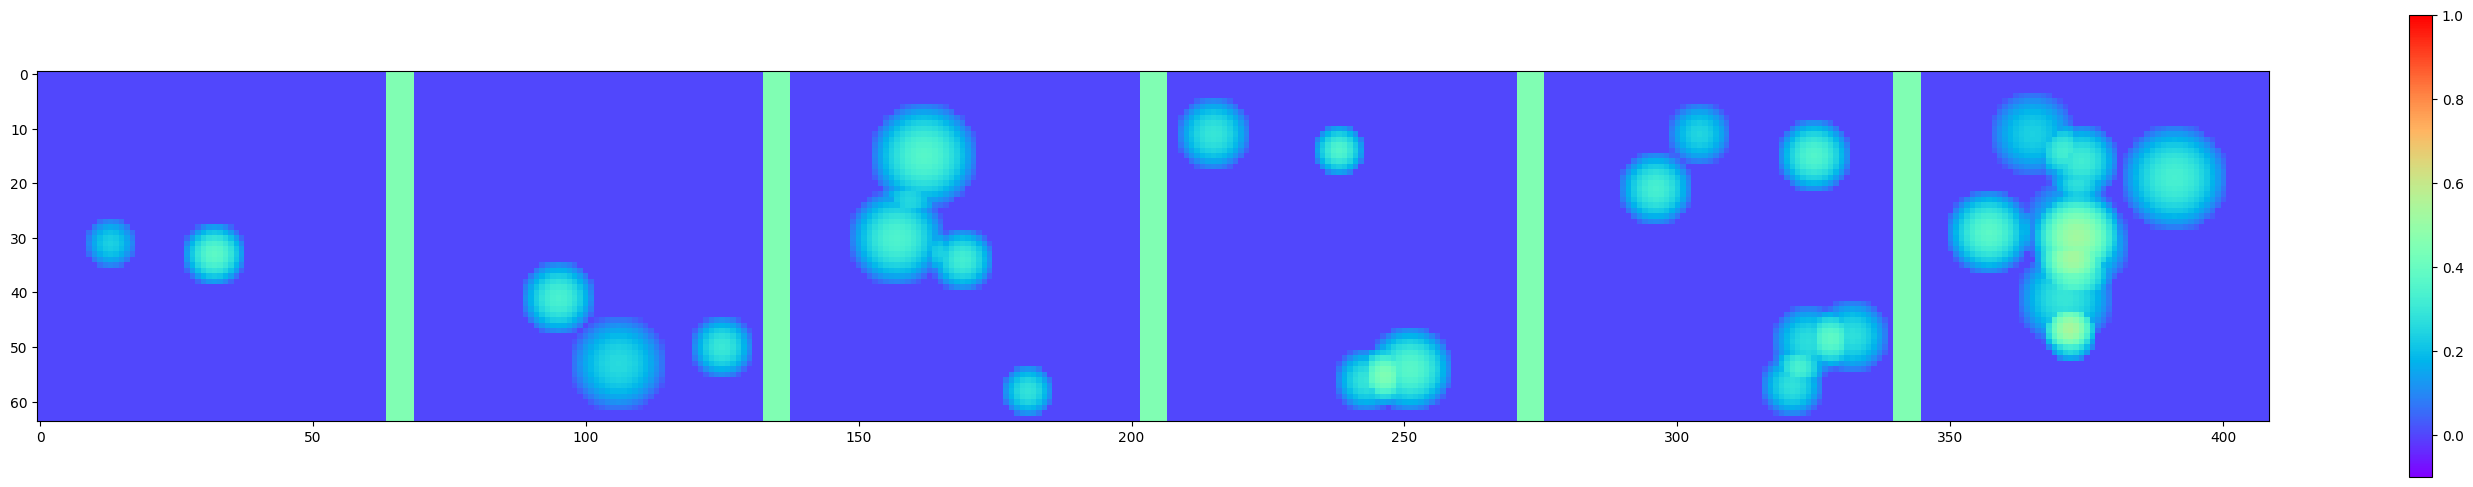

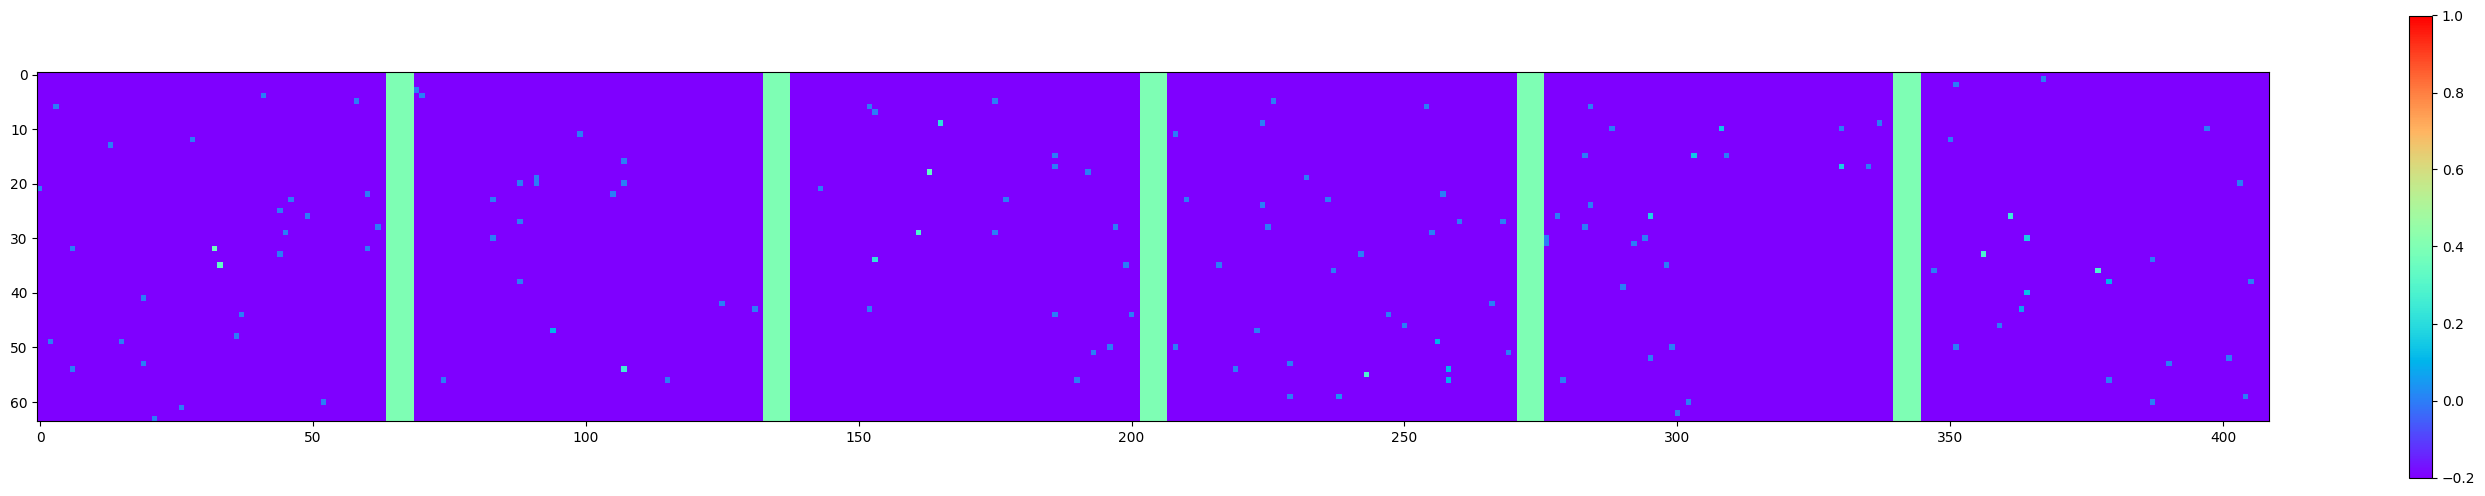

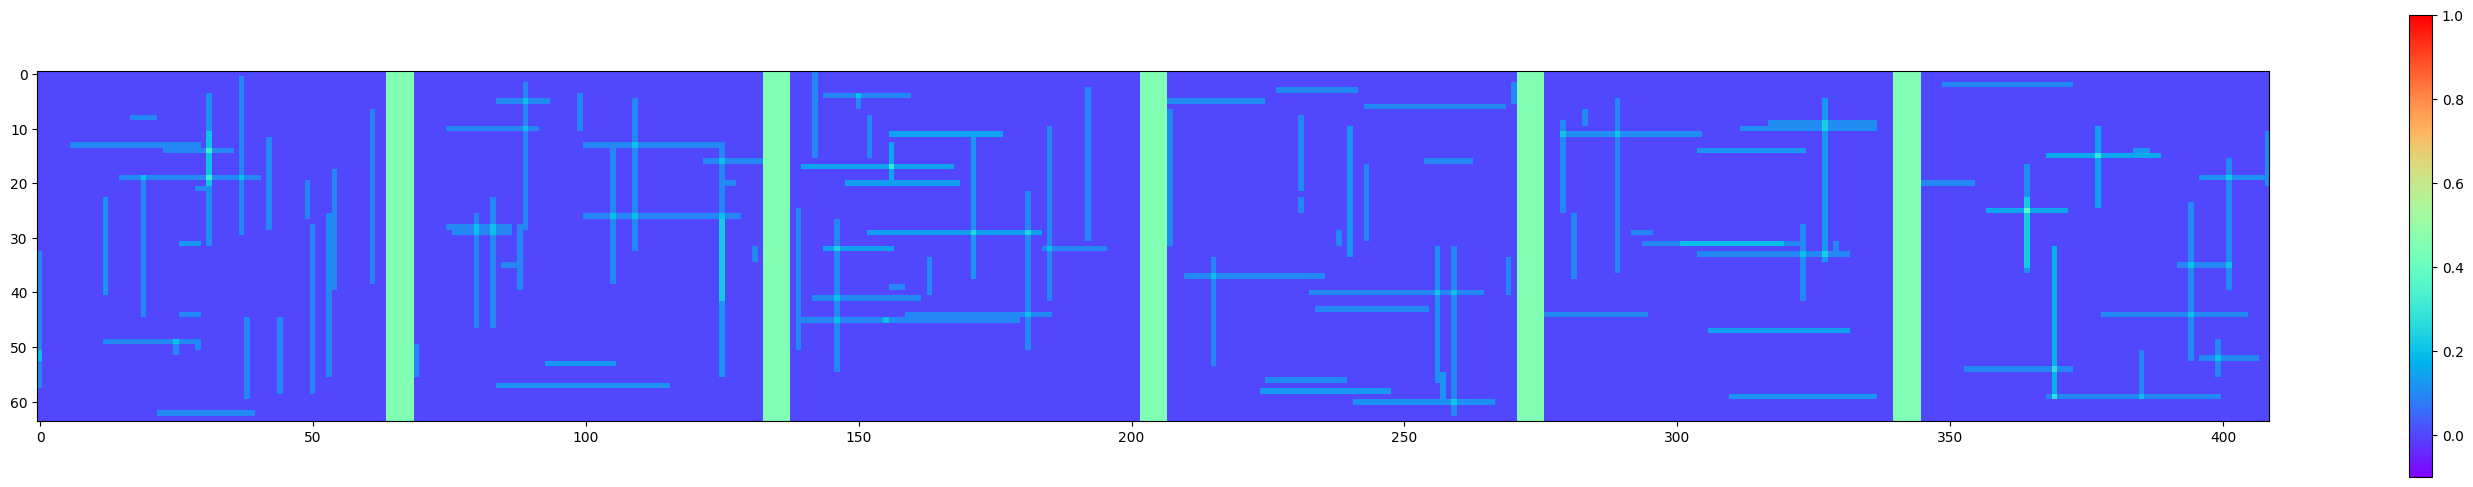

In [4]:
batch_size = 6
p = 0.5 / 100
full_target, partial_target, integrated_signals  = gen_image_with_integrated_signals(batch_size, p)


fig1 = plt.figure(1, figsize=(36, 6))
# champ T
voir_batch2D(full_target, 6, fig1, k=0, min_scale=-0.1, max_scale=1)

# mesures ponctuelles
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_target, 6, fig2, k=0, min_scale=-0.2, max_scale=1)

# représentation des données d'opportunité par des segments
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(integrated_signals, 6, fig3, k=0, min_scale= -0.1, max_scale=1)

Dans la cellule précédente, la fonction *gen_image_with_integrated_signals* permet de visualiser le jeu simulé:
- *full_target* représente le champ $T$ sur la zone couverte par l'imagette. Il s'agit de disques de valeurs positives.
- *partial_target* représente les mesures ponctuelles. En dehors des points de mesure, la valeur est fixée à -1.
- *integrated_signals* contient la représentation par segments. En dehors des segments, la valeur est fixée à 0. Dans cette simulation simpliste, les segments ont tous été supposés parallèles à l'un des deux côtés de l'imagette. De plus, $S$ a été modélisé comme une fonction affine, croissante de la valeur moyenne sur le segment. Ainsi, l'intensité d'un segment croit avec le nombre de disques traversés.



Dans cette partie, le but est de dire:\
**A.** si l'on peut entraîner avec succès un *FCN* à restituer $T$ à partir de données d'opportunité représentées par des segments (**exercice 1**).\
**B.** si en combinant des données d'opportunité aux mesures ponctuelles, on améliore bien les performances d'un $FCN$ (**exercice 2**).

**Exercice 1**

**Q1** Dans la cellule suivante, instancier un UNet. Choisir correctement *ch_in* et *ch_out*.

In [5]:
#Regarder la taille de l'image pour savoir le ch_in avec img.sheet()
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in, ch_out, size).cuda()

**Q2** Combien de poids ce réseau contient-il ? Ecrire le calcul ou intégrer un bout de code qui conduit au résultat.

In [6]:
# Pour voir les noms des couches contenues dans UNEt
for module in fcn.modules():
    print(module.__class__.__name__)

UNet
inconv
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Down
Sequential
MaxPool2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
Up
ConvTranspose2d
double_conv
Sequential
Conv2d
BatchNorm2d
ReLU
Conv2d
BatchNorm2d
ReLU
outconv
Conv2d
outconv
Conv2d


In [7]:
nb_weights = 0
for module in fcn.modules():
  # On compte les poids des couches qui en contiennent (attention aux doublons!):
  #Modules contenus dans Unet
  if isinstance(module, nn.Conv2d)\
    or isinstance(module, nn.BatchNorm2d)\
    or isinstance(module, nn.ConvTranspose2d):
    print(module.__class__.__name__)
    for parameter in module.parameters():
      nb_weights += torch.numel(parameter)
print("nb de poids : " + str(nb_weights))

# Il y a 232546 poids

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
ConvTranspose2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
Conv2d
nb de poids : 232546


**Q3** Présenter brièvement les types de couches utilisées dans ce réseau.

On trouve:
- des couches de convolutions. Ces couches sont caractérisées par des noyaux qui contiennent les poids (un neurone = un noyau). Pour cette version du UNet, chaque noyau, passé sur l'image d'entrée, fournit une carte de carastéristique de dimensions spatiales égales (ce n'est pas le cas dans un ResNet, à cause du paramètre stride>1...).
- des Maxpooling. Ici, ces couches réduisent la taille de l'image intermédiaire en prenant les valeurs maximum sur des carrés de taille 2X2, canal par canal.
- des couches de convolution transposées avec stride = 2. Elles génèrent des cartes de caractéristiques dont les dimensions spatiales sont le double de celles de l'image d'entrée.
- des fonctions d'activation non-linéaires ReLU (partie positive).

**Q4** Dans la cellule suivante, coder en une ligne l'erreur absolue moyenne.

In [11]:
def criterion(output,target):
  return torch.mean(torch.abs(output-target))

**Q5** Instancier l'optimizer Adam avec un taux d'apprentissage de 0.0002.

In [ ]:
torch.manual_seed(0)
optimizer = optim.Adam(fcn.parameters(), 2*10**(-4))

**Q6** Pourquoi est-il nécessaire de passer par une étape de validation lors d'un apprentissage ? Pourquoi peut-on s'en passer dans le cas où les images sont générées la volée ?

Pour garantir les performances en généralisation sur le jeu de test. Autrement dit: l'étape de validation permet de s'assurer qu'il n'y a pas surapprentissage du jeu d'entraînement.

**Q7** Ecrire la boucle d'apprentissage. On stockera la MAE à chaque époque.
- nombre d'époques : 30
- batches par époque : 100
- taille de batch : 32

In [ ]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses_is = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size, p)


        input = integrated_signals.cuda()
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_is.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

**Q8** Visualisez les résultats. Quelle conséquence visible le choix de la fonction de coût a-t-il eu ? Conclure sur le point **A.**

In [ ]:
plt.plot(train_losses_is)
plt.title('courbe d apprentissage')

In [ ]:
#visualisation:

fcn.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input = integrated_signals.cuda()

output = fcn(input)


In [ ]:
fig = plt.figure(0, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(input.cpu(), 6, fig, k=0, min_scale= 0.09,max_scale=0.11)
fig2 = plt.figure(1, figsize=(36, 6))  #seconde ligne: vérité terrain
voir_batch2D(full_target + (input.cpu())*10, 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output.detach().cpu() + (input.cpu())*10, 6, fig2, k=0, min_scale=0,max_scale=1.)

A trente époques, l'apprentissage n'est pas terminé; pourtant, le réseau a appris à former des plages de valeurs positives régulières:
- sous les segments les plus intenses;
- évitant les segments sur lesquels $T$ est de valeur nulle;
- discoïdes lorsque plusieurs segments intenses se recoupent.

Par contre:
- le réseau ne tient pas assez compte des segments qui traduisent une valeur moyenne faible mais non nulle.
- les artefacts sont encore nombreux (traces linéaires au sein des plages).

Une conséquence de la MAE, comparée à la MSE, c'est d'éviter un bruit strictement positif dans les zones où les segments sont absents (médiane considionnelle nulle).



**Note**: la médiane conditionnelle au signal d'entrée n'a pas de raison d'être structurée en disques. Des disques ne sont attendus que dans la situation où le problème peut être inversé (par exemple, aux endroits où les signaux d'entrée sont nombreux).

**Exercice 2**

On souhaite montrer qu'un *fcn* peut utiliser simultanément les deux types de signaux (mesures ponctuelles et données d'opportunité).
Reprendre le code de **l'exercice 1** avec les deux champs en entrée. Comparer les performances aux plans quantitatif (courbes d'apprentissage) et qualitatif. Conclure

In [ ]:
# Apprentissage avec les données ponctuelles seules:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet(ch_in,ch_out,size).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 30
nbatches = 100
batchsize = 32

train_losses_pt = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, _ = gen_image_with_integrated_signals(batch_size, p)


        input = partial_target.cuda()
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_pt.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)

In [ ]:
# Apprentissage avec les deux champs en entrée:
ch_in = 2
ch_out = 1
size = 8

fcn = UNet(ch_in,ch_out,size).cuda()

optimizer = optim.Adam(fcn.parameters(), 10**(-4))

In [ ]:
nepochs = 30
nbatches = 100
batch_size = 32
p = 0.5 / 100
train_losses_2ch = []


for epoch in range(nepochs):


    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #Load inputs


        full_target, partial_target, integrated_signals =\
                       gen_image_with_integrated_signals(batch_size, p)


        input = torch.cat((integrated_signals.cuda(), partial_target.cuda()), dim=1)
        target = full_target.cuda()


        optimizer.zero_grad()
        output = fcn(input)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()


        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses_2ch.append(epoch_loss)

    print('epoch loss : \n')
    print(epoch_loss)


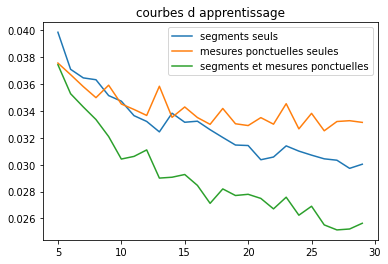

In [ ]:
plt.plot(range(5,30), train_losses_is[5:])
# cette deuxième courbe permettait d'affiner la conclusion:
plt.plot(range(5,30),train_losses_pt[5:])
plt.plot(range(5,30),train_losses_2ch[5:])
plt.title('courbes d apprentissage')
plt.legend(['segments seuls', 'mesures ponctuelles seules', 'segments et mesures ponctuelles'])

Les courbes d'apprentissage montrent l'avantage  d'un entraînement avec les deux entrées concaténées comparé au cas où seuls les segments sont disponibles.
Cela suggère que le réseau peut effectivement tirer parti des deux champs.

Pour affiner la conclusion, il était intéressant d'entraîner le modèle sur les mesures ponctuelles (courbe orange) pour s'assurer que l'ajout des mesures intégrées sur les segments n'a pas un effet négatif sur les performances.

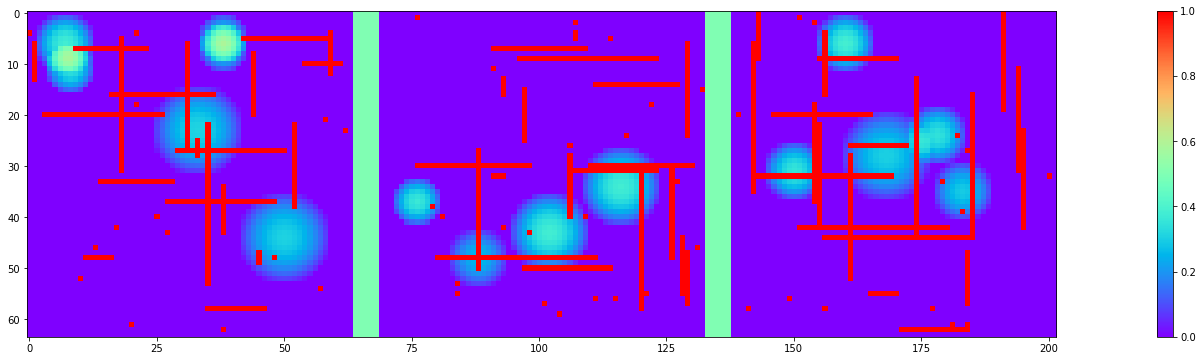

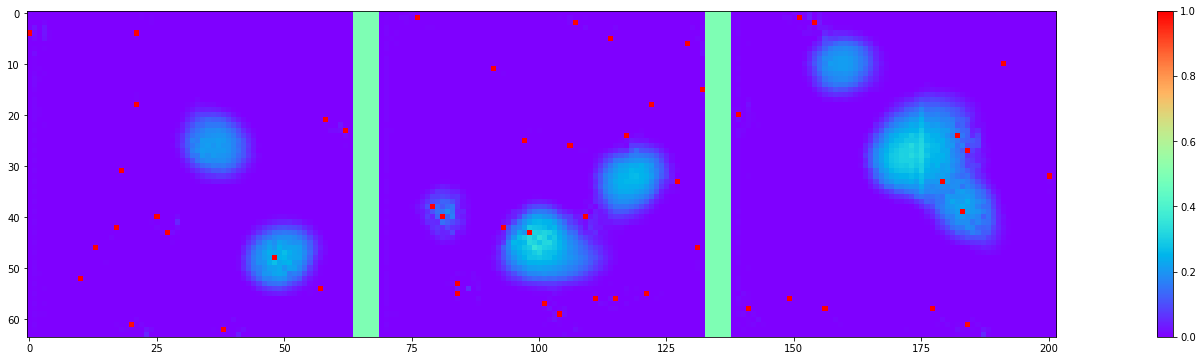

In [ ]:
fcn.eval()
batch_size_test = 3
full_target, partial_target, integrated_signals = gen_image_with_integrated_signals(batch_size_test, p)

input = torch.cat((integrated_signals.cuda(), partial_target.cuda()), dim=1)

output = fcn(input)

output = output.detach().cpu()
input = input.detach().cpu()
input_seg = input[:,[0],:,:]
input_point = input[:,[1],:,:]

full_target[input_seg > 0] = 1
full_target[input_point >= 0] = 1

fig2 = plt.figure(1, figsize=(36, 6))  #première ligne: vérité terrain
voir_batch2D(full_target, 6, fig2, k=0, min_scale=0,max_scale=1)
fig3 = plt.figure(2, figsize=(36, 6))  #seconde ligne: sorties
voir_batch2D(output.detach().cpu() + (input.cpu()[:,[1],:,:]>=0).float(), 6, fig2, k=0, min_scale=0,max_scale=1)


Sur les images en sortie, on constate que le réseau tient aussi bien compte des segments que des points pour former des plages de valeurs positives (voir par exemple le disque le plus à gauche sur les images de la deuxième colonne).
